In [1]:
import sys
sys.path.insert(1,'./decoders')
sys.path.insert(1,'./Instances_models')
sys.path.insert(1,'./Evaluators')
sys.path.insert(1,'./Utils')
from TSP_decoder import TSPDecoder
from TSP_instance import TSPInstance
from Datasets import FNN_dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os    
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

burma14 : 3323

In [2]:
instance  = TSPInstance(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Instances_data_TSP\burma14.dat')
decoder = TSPDecoder(instance)

In [3]:
chromossomes = np.loadtxt(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Initial Populations\chromosomes_1.txt')
fitness = np.loadtxt(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Initial Populations\fitness_1.txt')
lista = [chromossomes,fitness]


In [4]:
init_pop = pd.DataFrame(data=chromossomes)

In [5]:
init_pop['Fitness'] = fitness

In [6]:
print(f'maximo: {fitness.max()}  minimo {fitness.min()}')

maximo: 8829.0  minimo 4176.0


In [7]:
best = np.argsort(fitness)
print(best[0:3])

[8141 8542 9106]


In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(chromossomes,fitness,test_size=0.2,random_state=42)



In [9]:
class Population_dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float)
        self.y = torch.tensor(y,dtype=torch.float)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        cromossome = self.x[idx]
        fit = self.y[idx]
        return chromossome,fit
    

In [10]:
class VAautoencoder(nn.Module):
    def __init__(self,input_dim,h_dim,z_dim):
        super().__init__()
        
        self.fitness = nn.Linear(z_dim,1 )
        #encoder
        self.entrada = nn.Linear(input_dim,h_dim)
        self.sigma = nn.Linear(h_dim,z_dim)
        self.mu = nn.Linear(h_dim,z_dim)

        #decode
        self.z_2hidden = nn.Linear(z_dim,h_dim)
        self.output = nn.Linear(h_dim,input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self,x):
        h = self.relu(self.entrada(x))
        mu = self.mu(h)
        sigma = self.sigma(h)
        return mu ,sigma
    
    def decode(self,z):
        h = self.relu(self.z_2hidden(z))
        output = self.sigmoid(self.output(h))
        return output
    
    def forward(self,x):
        mu,sigma = self.encode(x)
        epsilon = torch.rand_like(sigma)
        z_reparametrizado = mu + torch.exp(sigma/2)*epsilon
        pred_value = self.fitness(z_reparametrizado)
        x_reconstruido = self.decode(z_reparametrizado)
        return x_reconstruido,mu,sigma,pred_value
        

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMPUT_DIM = 14
H_DIM = 10
Z_DIM = 7
NUM_EPOCH = 300
LA_RATE = 3e-4

In [12]:
modelVAE = VAautoencoder(IMPUT_DIM,H_DIM,Z_DIM)
optimizerVAE = torch.optim.Adam(modelVAE.parameters(),lr=LA_RATE)
loss_func = nn.MSELoss()
loss_per_epoch_VAE = np.zeros(NUM_EPOCH)
prediction_loss = np.zeros(NUM_EPOCH)

In [13]:
train_dataset = Population_dataset(X_train,Y_train)
test_dataset = Population_dataset(X_test,Y_test)

train_dataloader = DataLoader(train_dataset,batch_size=100,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=100,shuffle=False)

In [14]:

def train_model(model,optimizer,loss_func,NUM_EPOCH,dataloader,loss_per_epoch,prediction_loss):
    for epoch in range(NUM_EPOCH):
        for index, (x,y) in enumerate(dataloader):
            x_reconstructed, mu, sigma,pred = model(x)
            recons_loss= loss_func(x_reconstructed,x)
            kl_div = -0.5*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            fit_error = loss_func(pred,y)
            
            optimizer.zero_grad() 
            loss_val = recons_loss + kl_div  + fit_error
            
            loss_val.backward()
            optimizer.step()
            
            loss_per_epoch[epoch] = loss_val 
            prediction_loss[epoch] = fit_error
            
            
        if epoch % 10 ==0:   
            print(f"Epoch {epoch}, Erro Treino: {loss_per_epoch[epoch]}")
            
            

In [15]:

train_model(modelVAE,optimizerVAE,loss_func,NUM_EPOCH,train_dataloader,loss_per_epoch_VAE,prediction_loss)

C:\Users\Felipe\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Erro Treino: 44958540.0
Epoch 10, Erro Treino: 42514476.0
Epoch 20, Erro Treino: 39872260.0
Epoch 30, Erro Treino: 26721962.0
Epoch 40, Erro Treino: 29743104.0
Epoch 50, Erro Treino: 23520372.0
Epoch 60, Erro Treino: 14008794.0
Epoch 70, Erro Treino: 13663420.0
Epoch 80, Erro Treino: 16984564.0
Epoch 90, Erro Treino: 14190386.0
Epoch 100, Erro Treino: 9640067.0
Epoch 110, Erro Treino: 8375263.0
Epoch 120, Erro Treino: 4923152.0
Epoch 130, Erro Treino: 4194885.0
Epoch 140, Erro Treino: 3866265.0
Epoch 150, Erro Treino: 3439473.0
Epoch 160, Erro Treino: 3602995.0
Epoch 170, Erro Treino: 3341055.5
Epoch 180, Erro Treino: 3532012.25
Epoch 190, Erro Treino: 4373848.0
Epoch 200, Erro Treino: 3843930.5
Epoch 210, Erro Treino: 3670656.0
Epoch 220, Erro Treino: 3553116.5
Epoch 230, Erro Treino: 3193826.5
Epoch 240, Erro Treino: 3911139.5
Epoch 250, Erro Treino: 3644895.75
Epoch 260, Erro Treino: 3050650.0
Epoch 270, Erro Treino: 2763493.75
Epoch 280, Erro Treino: 3205254.75
Epoch 290, 

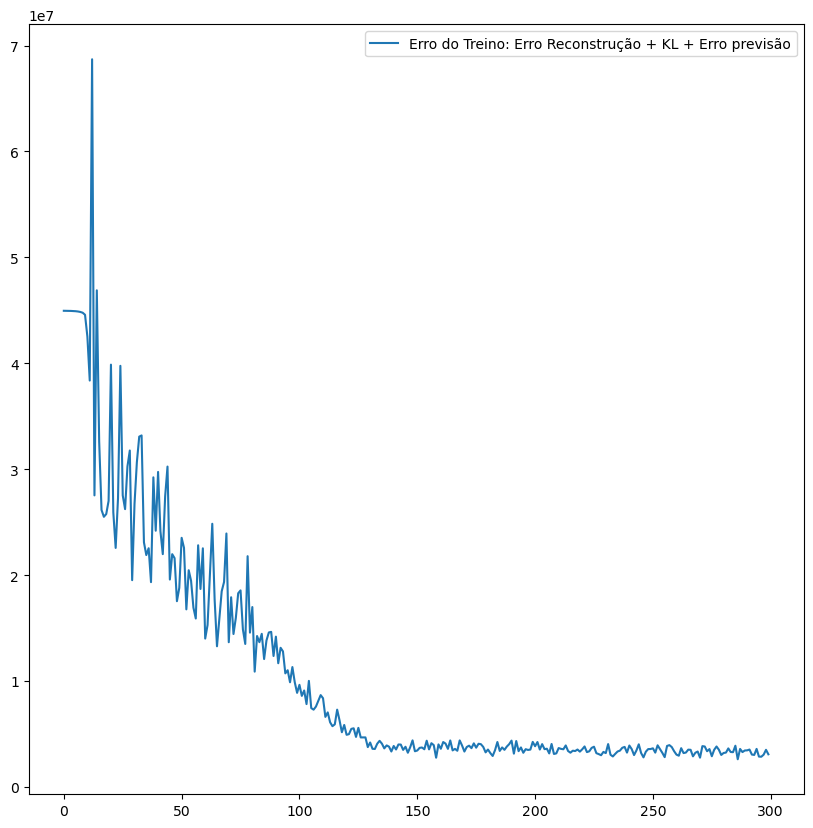

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(loss_per_epoch_VAE, label='Erro do Treino: Erro Reconstrução + KL + Erro previsão')
plt.legend()
plt.show()

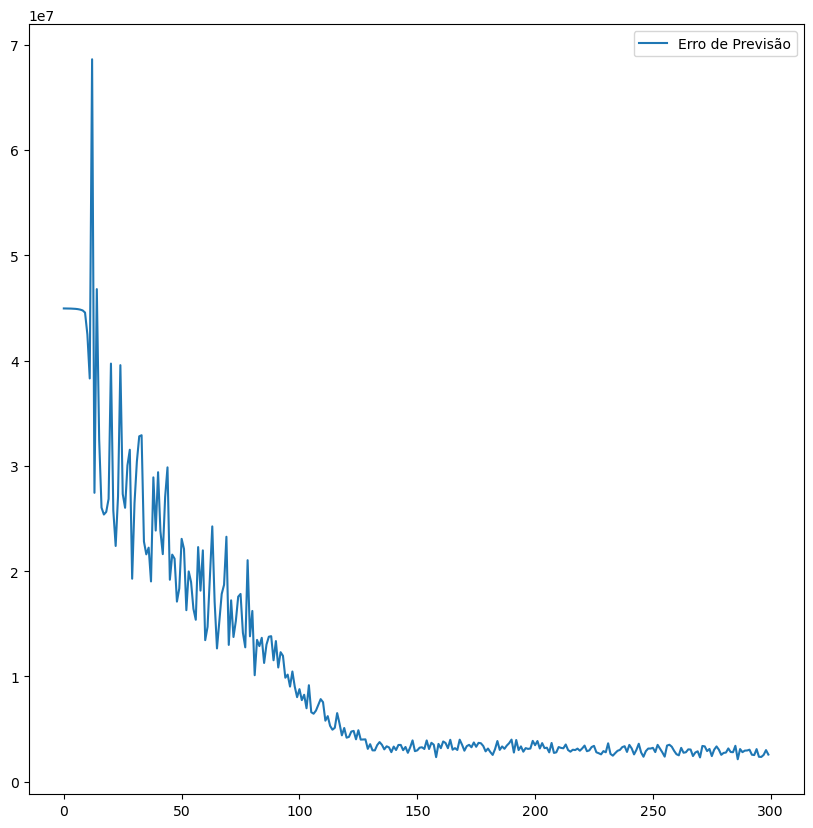

In [17]:
plt.figure(figsize=(10,10))
plt.plot(prediction_loss, label='Erro de Previsão')
plt.legend()
plt.show()

In [18]:
with torch.no_grad():
    mu,sigma = modelVAE.encode(torch.tensor(X_train,dtype=torch.float))
    epsilon = torch.rand_like(sigma)
    z_train = mu + torch.exp(sigma/2)*epsilon
    

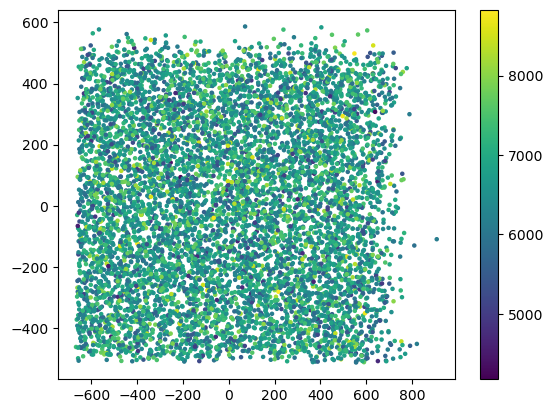

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
reduced_data = pca.fit_transform(z_train)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=Y_train, cmap='viridis', s=5)
plt.colorbar()
plt.show()

In [22]:
pca.explained_variance_ratio_

array([4.11673196e-01, 2.27888361e-01, 1.92359666e-01, 1.68076779e-01,
       1.94761603e-06])